In [4]:
pip install xgboost

^C
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import xgboost as xgb
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")

def load_data(file_path='all_features.csv'):
    """Load the feature data from CSV file."""
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded data with {df.shape[0]} rows and {df.shape[1]} columns.")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def preprocess_data(df):
    """Preprocess the data for XGBoost."""
    # Make a copy to avoid modifying the original DataFrame
    df_processed = df.copy()
    
    # Extract target variable from char_name column
    target = df_processed['char_name']
    
    # Remove non-feature columns
    features = df_processed.drop(['file_name', 'char_name'], axis=1)
    
    # Handle missing values
    features = features.fillna(features.mean())
    
    # Encode target labels
    label_encoder = LabelEncoder()
    target_encoded = label_encoder.fit_transform(target)
    
    print(f"Data preprocessed: {features.shape[1]} features available.")
    print(f"Target classes: {label_encoder.classes_}")
    
    return features, target_encoded, label_encoder.classes_

def train_xgboost_model(X_train, y_train, X_test, y_test):
    """Train an XGBoost classifier."""
    # Initialize the XGBoost classifier
    xgb_clf = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    
    # Train the model
    xgb_clf.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=10,
        verbose=True
    )
    
    # Plot and save learning curves
    results = xgb_clf.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    
    plt.figure(figsize=(12, 8))
    plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    plt.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    plt.legend()
    plt.title('XGBoost Log Loss', fontsize=16)
    plt.xlabel('Number of Boosting Rounds', fontsize=14)
    plt.ylabel('Log Loss', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('xgboost_learning_curve.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return xgb_clf

def evaluate_model(model, X_test, y_test, class_names):
    """Evaluate the XGBoost model performance."""
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, target_names=class_names)
    print(report)
    
    # Save classification report as an image
    plt.figure(figsize=(10, 6))
    plt.text(0.01, 0.99, f"Accuracy: {accuracy:.4f}\n\n" + report, va='top', ha='left', fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('xgboost_classification_report.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('xgboost_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Calculate multi-class ROC AUC
    roc_auc = {}
    n_classes = len(class_names)
    
    if n_classes <= 10:  # Only plot ROC curves if there are not too many classes
        plt.figure(figsize=(12, 10))
        
        for i in range(n_classes):
            # For each class, calculate the ROC curve and ROC area
            fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_prob[:, i])
            roc_auc[i] = auc(fpr, tpr)
            
            # Plot ROC curve for the class
            plt.plot(fpr, tpr, lw=2, 
                     label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')
        
        # Plot the diagonal reference line
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Multi-class ROC Curves', fontsize=16)
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig('xgboost_roc_curves.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    return accuracy, y_pred, y_prob

def plot_feature_importance(model, feature_names):
    """Plot feature importance from XGBoost model."""
    # Get feature importance from the model (weight, gain, cover)
    importance_types = ['weight', 'gain', 'cover']
    
    for importance_type in importance_types:
        # Plot feature importance using xgboost's built-in function
        plt.figure(figsize=(12, 10))
        plot_importance(model, importance_type=importance_type, max_num_features=30, 
                       title=f'XGBoost Feature Importance ({importance_type})',
                       xlabel='F Score', grid=False)
        plt.tight_layout()
        plt.savefig(f'xgboost_importance_{importance_type}.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Plot feature importance as a bar chart (more customizable)
        importance = model.get_booster().get_score(importance_type=importance_type)
        importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
        
        features = [x[0] for x in importance[:30]]
        scores = [x[1] for x in importance[:30]]
        
        plt.figure(figsize=(12, 10))
        plt.barh(range(len(scores)), scores, align='center')
        plt.yticks(range(len(scores)), features)
        plt.title(f'XGBoost Top 30 Feature Importance ({importance_type})', fontsize=16)
        plt.xlabel('Importance', fontsize=12)
        plt.gca().invert_yaxis()  # Display the highest scores at the top
        plt.tight_layout()
        plt.savefig(f'xgboost_top_features_{importance_type}.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # Get feature importance (using 'gain' as default)
    importance = model.get_booster().get_score(importance_type='gain')
    importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    
    # Return top 30 important features
    return importance[:30]

def plot_feature_distributions(features, target, target_names, top_features):
    """Plot distributions of top features by class."""
    # Get the feature names from the top features list
    top_feature_names = [feat[0] for feat in top_features[:10]]  # Take top 10
    
    # Create a figure for the distribution plots
    fig, axes = plt.subplots(5, 2, figsize=(20, 25))
    axes = axes.flatten()
    
    # Create a DataFrame with features and target
    df = pd.DataFrame(features)
    df.columns = features.columns
    df['target'] = target
    
    # Plot distribution for each top feature
    for i, feature in enumerate(top_feature_names):
        if i >= 10:  # Limit to 10 features
            break
            
        if feature in df.columns:
            sns.boxplot(x='target', y=feature, data=df, ax=axes[i])
            axes[i].set_title(f'Distribution of {feature}', fontsize=14)
            axes[i].set_xlabel('Class', fontsize=12)
            axes[i].set_ylabel(feature, fontsize=12)
            axes[i].set_xticklabels([target_names[j] for j in range(len(target_names))], rotation=45)
    
    plt.tight_layout()
    plt.savefig('xgboost_feature_distributions.png', dpi=300, bbox_inches='tight')
    plt.close()

def tune_hyperparameters(X_train, y_train):
    """Tune hyperparameters for XGBoost using GridSearchCV."""
    print("Starting hyperparameter tuning (this may take some time)...")
    
    # Define the parameter grid
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'gamma': [0, 0.1, 0.2]
    }
    
    # Initialize the XGBoost classifier
    xgb_clf = xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    
    # Set up cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        verbose=2,
        n_jobs=-1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Save hyperparameter tuning results as an image
    plt.figure(figsize=(12, 8))
    plt.text(0.01, 0.99, f"Best Parameters:\n{grid_search.best_params_}\n\nBest CV Score: {grid_search.best_score_:.4f}",
             va='top', ha='left', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('xgboost_hyperparameter_tuning.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return grid_search.best_params_, grid_search.best_score_

def visualize_tree(model, output_file='xgboost_tree.png'):
    """Visualize the first tree in the XGBoost model."""
    try:
        # Get the first tree dump
        dump = model.get_booster().get_dump()[0]
        
        # Save tree visualization using xgboost's plot_tree
        plt.figure(figsize=(20, 15))
        xgb.plot_tree(model, num_trees=0)
        plt.title('First Decision Tree in XGBoost Model', fontsize=16)
        plt.tight_layout()
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Tree visualization saved to {output_file}")
    except Exception as e:
        print(f"Error visualizing tree: {e}")

def save_feature_importance_table(importance, output_file='xgboost_feature_importance.csv'):
    """Save feature importance as a CSV file and image."""
    # Create a DataFrame from the importance dictionary
    importance_df = pd.DataFrame({
        'Feature': [item[0] for item in importance],
        'Importance': [item[1] for item in importance]
    })
    
    # Save to CSV
    importance_df.to_csv(output_file, index=False)
    print(f"Feature importance table saved to {output_file}")
    
    # Save top 20 feature importance as image
    plt.figure(figsize=(10, 8))
    importance_table = importance_df.head(20).to_string(index=False)
    plt.text(0.01, 0.99, "Top 20 Features by Importance:\n\n" + importance_table, 
             va='top', ha='left', fontsize=12, family='monospace')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('xgboost_feature_importance_table.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return importance_df

def main():
    """Main function to run the XGBoost analysis."""
    print("Starting XGBoost analysis for time-series data...")
    
    # Create a summary image to capture console output
    console_output = []
    console_output.append("XGBoost Analysis for Time-Series Data\n")
    console_output.append("====================================\n")
    
    # Load the data
    df = load_data()
    if df is None:
        return
    
    console_output.append(f"Data loaded: {df.shape[0]} samples, {df.shape[1]} columns\n")
    
    # Preprocess the data
    features, target_encoded, class_names = preprocess_data(df)
    console_output.append(f"Preprocessed data: {features.shape[1]} features\n")
    console_output.append(f"Target classes: {', '.join(class_names)}\n")
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, target_encoded, test_size=0.25, random_state=42, stratify=target_encoded
    )
    
    console_output.append(f"Training set: {X_train.shape[0]} samples\n")
    console_output.append(f"Testing set: {X_test.shape[0]} samples\n")
    
    # Uncomment to run hyperparameter tuning (time-consuming)
    # best_params, best_score = tune_hyperparameters(X_train, y_train)
    # console_output.append(f"Best parameters: {best_params}\n")
    # console_output.append(f"Best CV score: {best_score:.4f}\n")
    
    # Train the XGBoost model
    console_output.append("\nTraining XGBoost model...\n")
    xgb_model = train_xgboost_model(X_train, y_train, X_test, y_test)
    console_output.append("XGBoost model trained successfully\n")
    
    # Evaluate the model
    console_output.append("\nEvaluating model performance...\n")
    accuracy, y_pred, y_prob = evaluate_model(xgb_model, X_test, y_test, class_names)
    console_output.append(f"Test accuracy: {accuracy:.4f}\n")
    
    # Plot and save feature importance
    console_output.append("\nAnalyzing feature importance...\n")
    importance = plot_feature_importance(xgb_model, features.columns)
    
    # Plot distributions of top features
    plot_feature_distributions(features, target_encoded, class_names, importance)
    
    # Visualize a tree from the model
    visualize_tree(xgb_model)
    
    # Save feature importance to CSV and as image
    importance_df = save_feature_importance_table(importance)
    
    # Calculate cross-validation score
    cv_scores = cross_val_score(xgb_model, features, target_encoded, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    console_output.append(f"\n5-fold Cross-validation Accuracy: {cv_mean:.4f} (+/- {cv_std * 2:.4f})\n")
    
    # Save the model
    model_filename = 'xgboost_model.json'
    xgb_model.save_model(model_filename)
    console_output.append(f"\nModel saved to '{model_filename}'\n")
    
    console_output.append("\nXGBoost analysis completed successfully!")
    
    # Save console output as image
    plt.figure(figsize=(12, 10))
    plt.text(0.01, 0.99, "".join(console_output), va='top', ha='left', fontsize=12, family='monospace')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('xgboost_analysis_summary.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    return xgb_model, importance_df

if __name__ == "__main__":
    main()

Starting XGBoost analysis for time-series data...
Successfully loaded data with 283 rows and 109 columns.
Data preprocessed: 107 features available.
Target classes: ['অ_36606b04_Right Hand_20250423_120617_preprocessed'
 'অ_36606b04_Right Hand_20250423_120731_preprocessed'
 'আ_36606b04_Right Hand_20250423_120748_preprocessed'
 'আ_36606b04_Right Hand_20250423_120805_preprocessed'
 'ক_01083526_Right Hand_20250423_122648_preprocessed'
 'ক_01083526_Right Hand_20250423_122659_preprocessed'
 'ক_01083526_Right Hand_20250423_122711_preprocessed'
 'ক_041c8727_Right Hand_20250425_143649_preprocessed'
 'ক_041c8727_Right Hand_20250425_143657_preprocessed'
 'ক_0e4e9ee0_Right Hand_20250426_005722_preprocessed'
 'ক_0e4e9ee0_Right Hand_20250426_005730_preprocessed'
 'ক_117fb6fc_Right Hand_20250423_122340_preprocessed'
 'ক_117fb6fc_Right Hand_20250423_122352_preprocessed'
 'ক_1703ad9a_Right Hand_20250425_144058_preprocessed'
 'ক_1703ad9a_Right Hand_20250425_144107_preprocessed'
 'ক_1703ad9a_Right Hand_2

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [3]:
import pandas as pd
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Load your CSV
df = pd.read_csv("all_features.csv")  # Make sure path is correct

# Step 2: Separate features and target
X = df.drop(columns=["file_name", "char_name"])  # drop non-feature columns
y = df["char_name"]  # target = alphabet name

# Step 3: Encode target labels (e.g., অ → 0, গ → 1, etc.)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 4: Drop classes with fewer than 2 samples
value_counts = pd.Series(y_encoded).value_counts()
valid_classes = value_counts[value_counts >= 2].index

# Apply mask using Pandas Series to avoid error
mask = pd.Series(y_encoded).isin(valid_classes)
X = X[mask]
y_encoded = y_encoded[mask]

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

# Step 6: Train the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Step 7: Plot feature importance
plt.figure(figsize=(12, 6))
plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("XGBoost Feature Importance (Top 20 Features)")
plt.tight_layout()
plt.show()

ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

              precision    recall  f1-score   support

           অ       0.00      0.00      0.00         1
           ক       0.90      0.75      0.82        12
           খ       0.60      0.82      0.69        11
           গ       0.69      0.82      0.75        11
           ঘ       1.00      0.64      0.78        11
           ঙ       0.83      0.91      0.87        11

    accuracy                           0.77        57
   macro avg       0.67      0.66      0.65        57
weighted avg       0.79      0.77      0.77        57



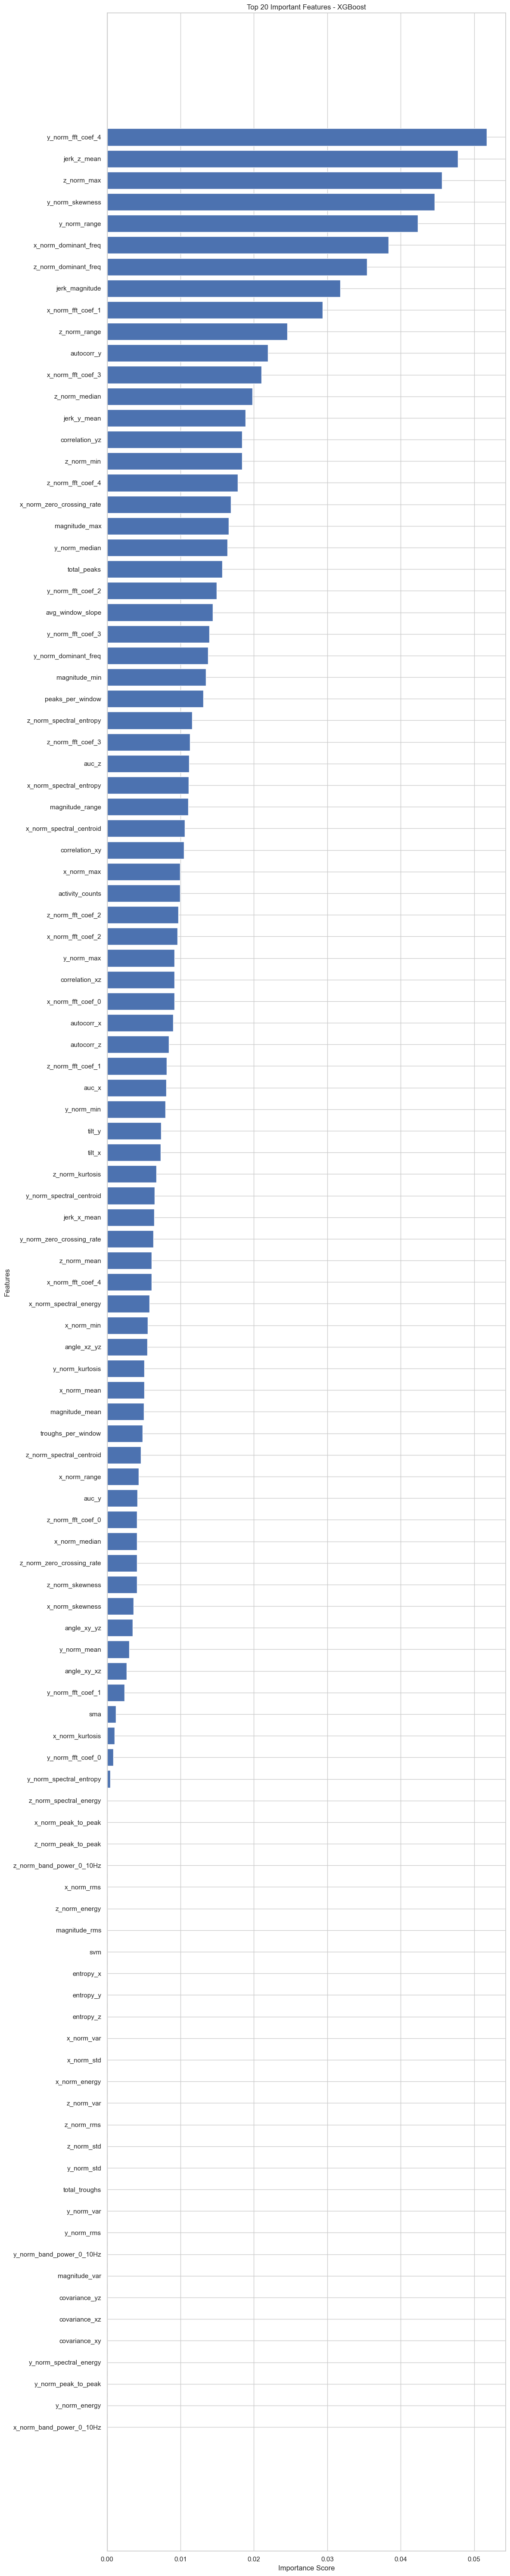

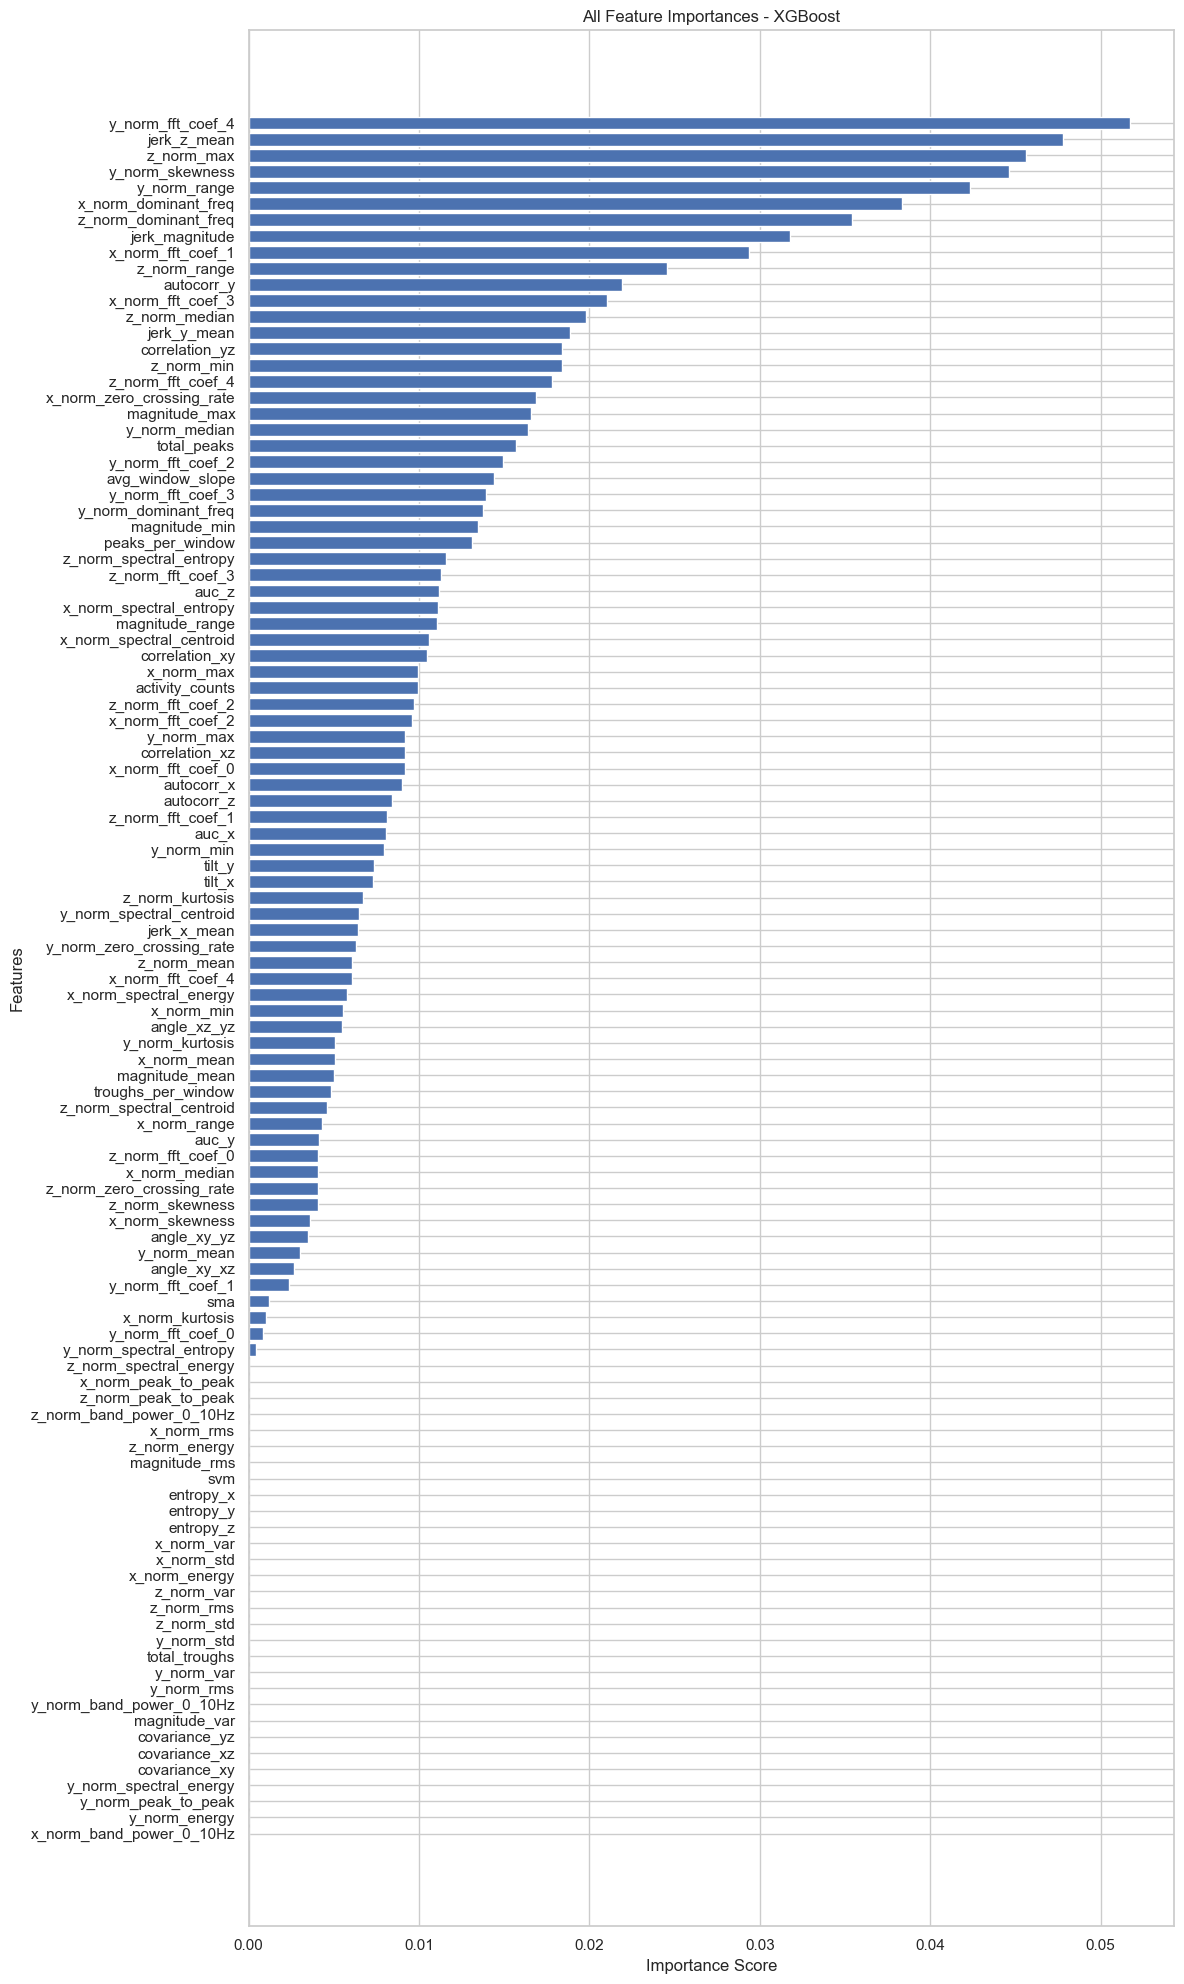


Top 20 Features:
                  Feature  Importance
        y_norm_fft_coef_4    0.051718
              jerk_z_mean    0.047793
               z_norm_max    0.045643
          y_norm_skewness    0.044597
             y_norm_range    0.042340
     x_norm_dominant_freq    0.038338
     z_norm_dominant_freq    0.035433
           jerk_magnitude    0.031768
        x_norm_fft_coef_1    0.029346
             z_norm_range    0.024528
               autocorr_y    0.021932
        x_norm_fft_coef_3    0.021051
            z_norm_median    0.019802
              jerk_y_mean    0.018885
           correlation_yz    0.018387
               z_norm_min    0.018379
        z_norm_fft_coef_4    0.017820
x_norm_zero_crossing_rate    0.016853
            magnitude_max    0.016554
            y_norm_median    0.016371


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Load the dataset
df = pd.read_csv('all_features.csv')

# Extract character names from file names
df['character'] = df['file_name'].str.split('_').str[0]

# Encode the target variable (character)
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['character'])

# Prepare features and target
X = df.drop(['file_name', 'char_name', 'character', 'target'], axis=1)
y = df['target']

# Split data into train and test sets - using stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # This ensures all classes are represented in both sets
)

# Initialize and train XGBoost model
model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

# Get the unique classes present in y_test
present_labels = np.unique(y_test)
present_target_names = label_encoder.inverse_transform(present_labels)

print(classification_report(
    y_test, 
    y_pred, 
    target_names=present_target_names,
    labels=present_labels
))

# Get feature importance
importance = model.feature_importances_

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Sort features by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 60))
plt.barh(feature_importance['Feature'][:], feature_importance['Importance'][:])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 20 Important Features - XGBoost')
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()

# Save the plot
plt.savefig('xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot all features (smaller font)
plt.figure(figsize=(12, 20))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('All Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('xgboost_all_features_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top features
print("\nTop 20 Features:")
print(feature_importance.head(20).to_string(index=False))

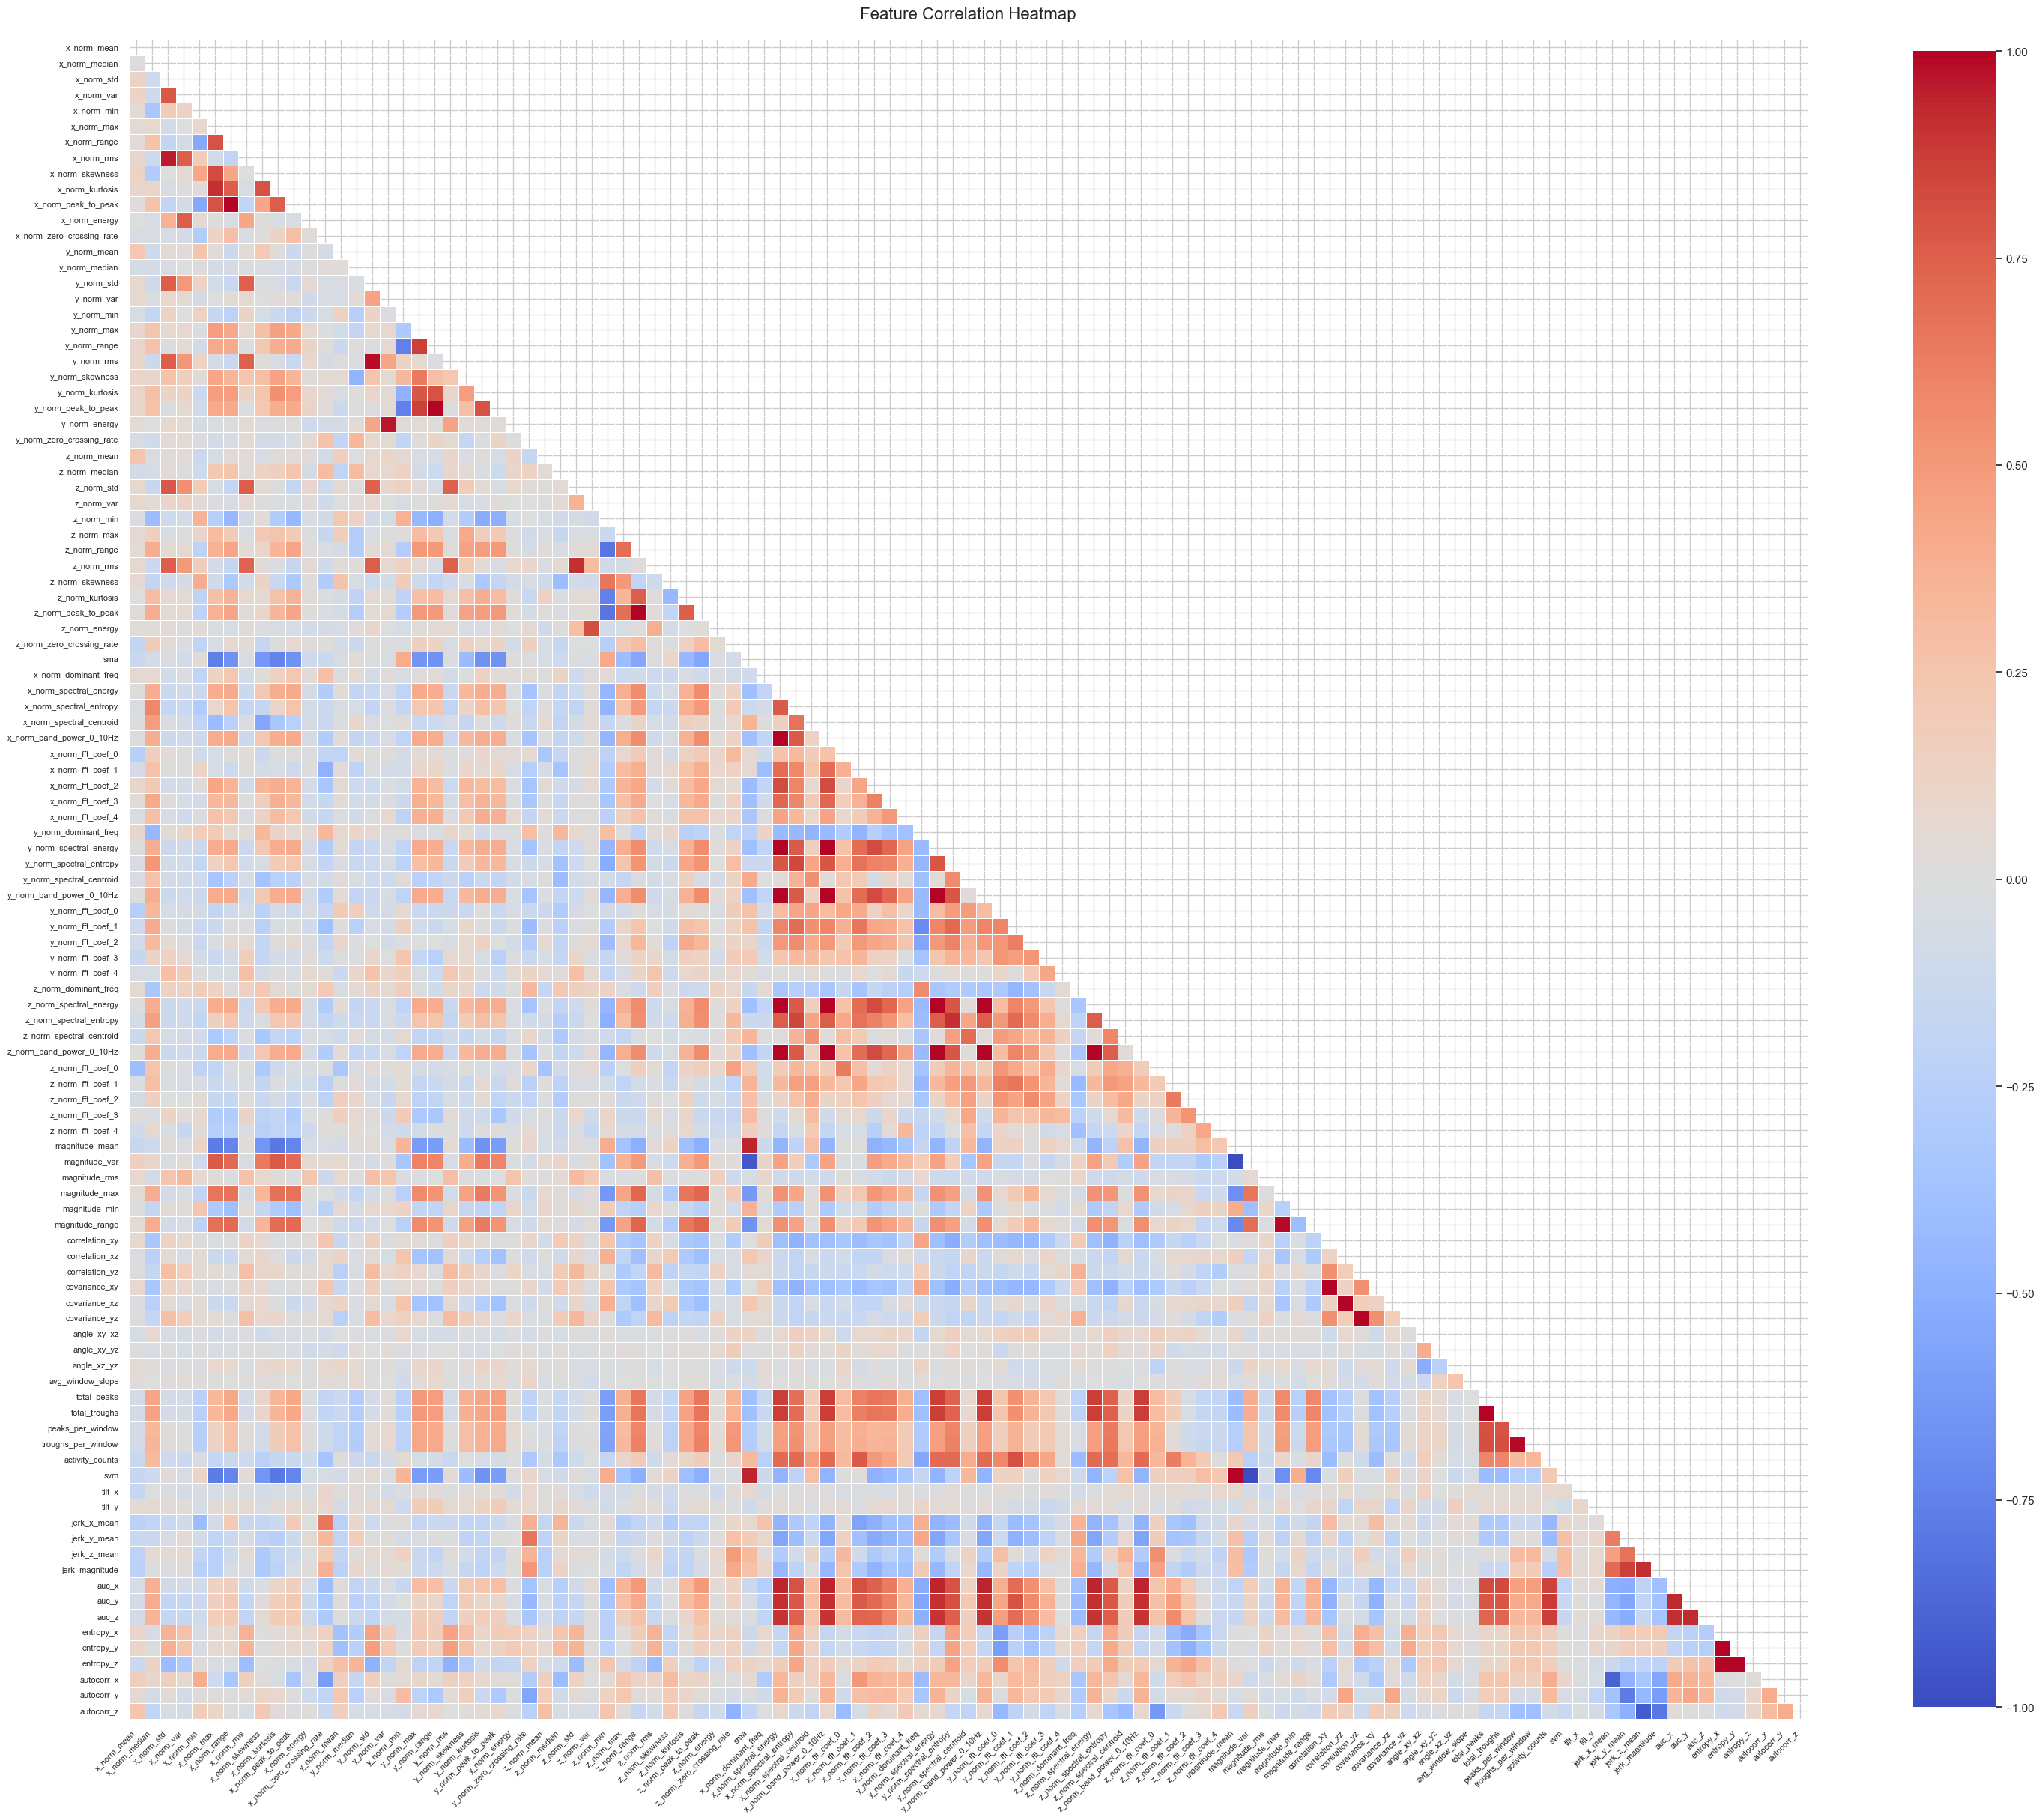


Top 20 Highest Feature Correlations:
              Feature1               Feature2  Correlation
             entropy_y              entropy_z          1.0
             entropy_x              entropy_y          1.0
             entropy_y              entropy_x          1.0
             entropy_z              entropy_y          1.0
   y_norm_peak_to_peak           y_norm_range          1.0
          x_norm_range    x_norm_peak_to_peak          1.0
   z_norm_peak_to_peak           z_norm_range          1.0
   x_norm_peak_to_peak           x_norm_range          1.0
          y_norm_range    y_norm_peak_to_peak          1.0
          z_norm_range    z_norm_peak_to_peak          1.0
                   svm         magnitude_mean          1.0
        magnitude_mean                    svm          1.0
             entropy_z              entropy_x          1.0
             entropy_x              entropy_z          1.0
y_norm_spectral_energy x_norm_spectral_energy          1.0
x_norm_spectral_en

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('all_features.csv')

# Extract character names from file names
df['character'] = df['file_name'].str.split('_').str[0]

# Prepare features - drop non-feature columns
features = df.drop(['file_name', 'char_name', 'character'], axis=1)

# Calculate correlation matrix
corr_matrix = features.corr()

# Set up the matplotlib figure
plt.figure(figsize=(30, 28))

# Create a mask to hide upper triangle (optional)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create heatmap with proper alignment
heatmap = sns.heatmap(
    corr_matrix, 
    mask=mask,  # Remove if you want full matrix
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot=False,  # Set to True if you want values in cells
    fmt=".2f"     # Format for annotations
)

# Rotate x-axis labels for better readability
heatmap.set_xticklabels(
    heatmap.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=8
)

# Rotate y-axis labels
heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    rotation=0,
    fontsize=8
)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Title
plt.title('Feature Correlation Heatmap', fontsize=16, pad=20)

# Save high-quality image
plt.savefig('feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

# For better analysis, let's identify high correlations
high_corr = corr_matrix.abs().stack().reset_index()
high_corr.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr = high_corr[high_corr['Feature1'] != high_corr['Feature2']]  # Remove self-correlations
high_corr = high_corr.sort_values('Correlation', ascending=False)

# Print top 20 highest correlations
print("\nTop 20 Highest Feature Correlations:")
print(high_corr.head(20).to_string(index=False))

In [13]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_data(filepath):
    """Load data, handle missing values, and preprocess"""
    try:
        df = pd.read_csv(filepath)
        
        # Extract character label from filename
        df['character'] = df['file_name'].str.split('_').str[0]
        
        # Drop unnecessary columns
        cols_to_drop = ['file_name', 'char_name']
        df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
        
        # Check for missing values
        print("\nMissing values before handling:")
        print(df.isna().sum().sort_values(ascending=False).head(10))
        
        # Handle missing values - option 1: Drop columns with too many NaNs
        df = df.dropna(axis=1, thresh=0.8*len(df))  # Keep columns with at least 80% non-NaN values
        
        # Handle remaining missing values - option 2: Impute with median
        imputer = SimpleImputer(strategy='median')
        df_imputed = pd.DataFrame(imputer.fit_transform(df.select_dtypes(include=np.number)),
                                columns=df.select_dtypes(include=np.number).columns)
        
        # Combine imputed numerical data with non-numerical data
        non_num_cols = df.select_dtypes(exclude=np.number).columns
        if len(non_num_cols) > 0:
            df_imputed = pd.concat([df_imputed, df[non_num_cols]], axis=1)
        
        # Encode character labels
        le = LabelEncoder()
        df_imputed['character'] = le.fit_transform(df_imputed['character'])
        
        # Verify no missing values remain
        print("\nMissing values after handling:")
        print(df_imputed.isna().sum().sum(), "missing values remaining")
        
        # Separate features and target
        X = df_imputed.drop(columns=['character'])
        y = df_imputed['character']
        
        return X, y, le.classes_
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

def perform_anova_with_nan_check(X, y):
    """Perform ANOVA with additional NaN checks"""
    # Final check for NaN/infinite values
    if np.isinf(X.values).any() or np.isnan(X.values).any():
        print("Warning: Data still contains NaN or infinite values after preprocessing")
        # Optionally replace remaining inf with large finite numbers
        X = X.replace([np.inf, -np.inf], np.nan)
        X = X.fillna(X.median())
    
    # Perform ANOVA
    f_values, p_values = f_classif(X, y)
    
    # Create results DataFrame
    anova_results = pd.DataFrame({
        'Feature': X.columns,
        'F_value': f_values,
        'p_value': p_values
    }).sort_values('F_value', ascending=False)
    
    return anova_results

def main():
    # Load your dataset
    filepath = 'all_features.csv'
    X, y, class_names = load_and_preprocess_data(filepath)
    
    if X is not None:
        # Perform ANOVA
        anova_results = perform_anova_with_nan_check(X, y)
        
        # Display and visualize results
        print("\nTop 20 Features by ANOVA F-value:")
        print(anova_results.head(20).to_string(index=False))
        
        # Select significant features (p < 0.01 and F > 10)
        significant_features = anova_results[
            (anova_results['p_value'] < 0.01) & 
            (anova_results['F_value'] > 10)
        ].sort_values('F_value', ascending=False)
        
        print(f"\nSelected {len(significant_features)} significant features:")
        print(significant_features[['Feature', 'F_value', 'p_value']].to_string(index=False))
        
        # Save selected features
        significant_features.to_csv('significant_features_anova.csv', index=False)
        print("\nResults saved to 'significant_features_anova.csv'")
    else:
        print("Failed to load and preprocess data")

if __name__ == "__main__":
    main()


Missing values before handling:
x_norm_mean          1
magnitude_min        1
magnitude_rms        1
magnitude_var        1
magnitude_mean       1
z_norm_fft_coef_4    1
z_norm_fft_coef_3    1
z_norm_fft_coef_2    1
z_norm_fft_coef_1    1
z_norm_fft_coef_0    1
dtype: int64

Missing values after handling:
0 missing values remaining

Top 20 Features by ANOVA F-value:
             Feature   F_value      p_value
       covariance_yz 23.820273 1.140870e-22
      correlation_yz 23.818293 1.145220e-22
z_norm_dominant_freq 19.147847 1.207622e-18
   y_norm_fft_coef_4 17.496872 3.678836e-17
   z_norm_fft_coef_4 10.563722 1.472987e-10
   y_norm_fft_coef_3  9.854388 7.534832e-10
          y_norm_min  8.638498 1.273447e-08
          z_norm_max  7.739913 1.051179e-07
 z_norm_peak_to_peak  6.841026 8.808592e-07
        z_norm_range  6.841026 8.808592e-07
     y_norm_skewness  5.810453 1.018670e-05
          z_norm_min  5.709855 1.293896e-05
       x_norm_median  4.563301 1.963623e-04
              

In [18]:
pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



Visualizing missing data patterns...


<Figure size 1200x600 with 0 Axes>

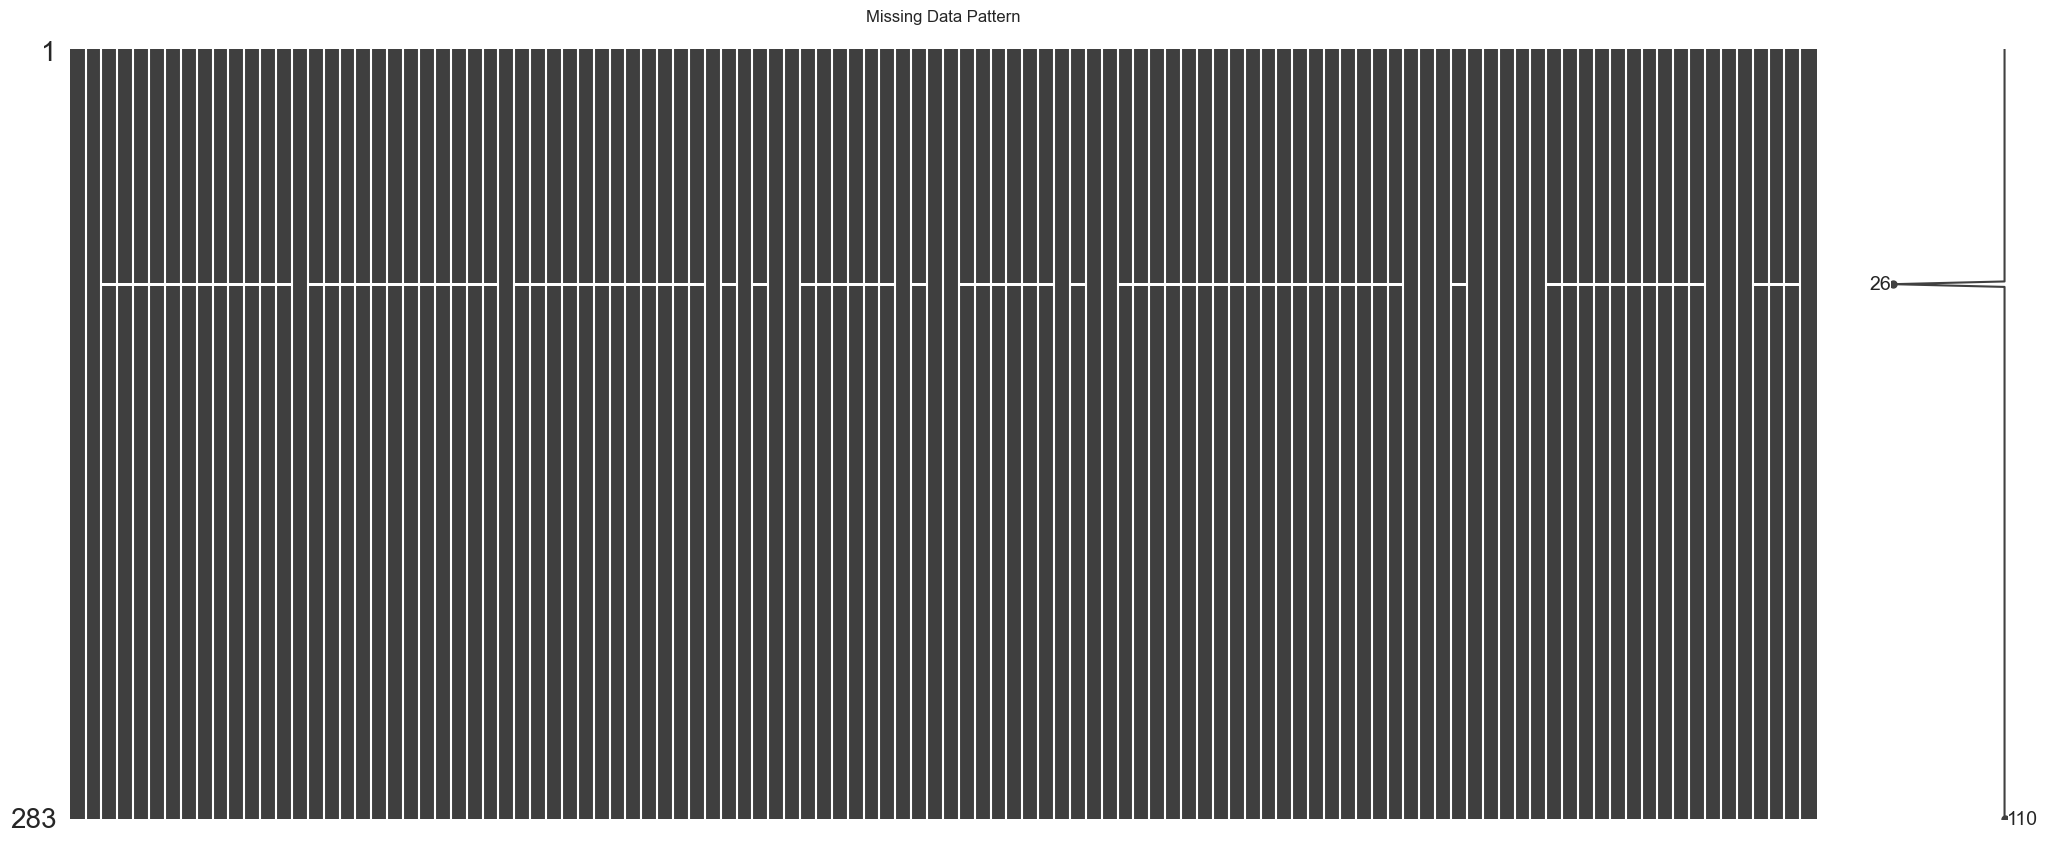

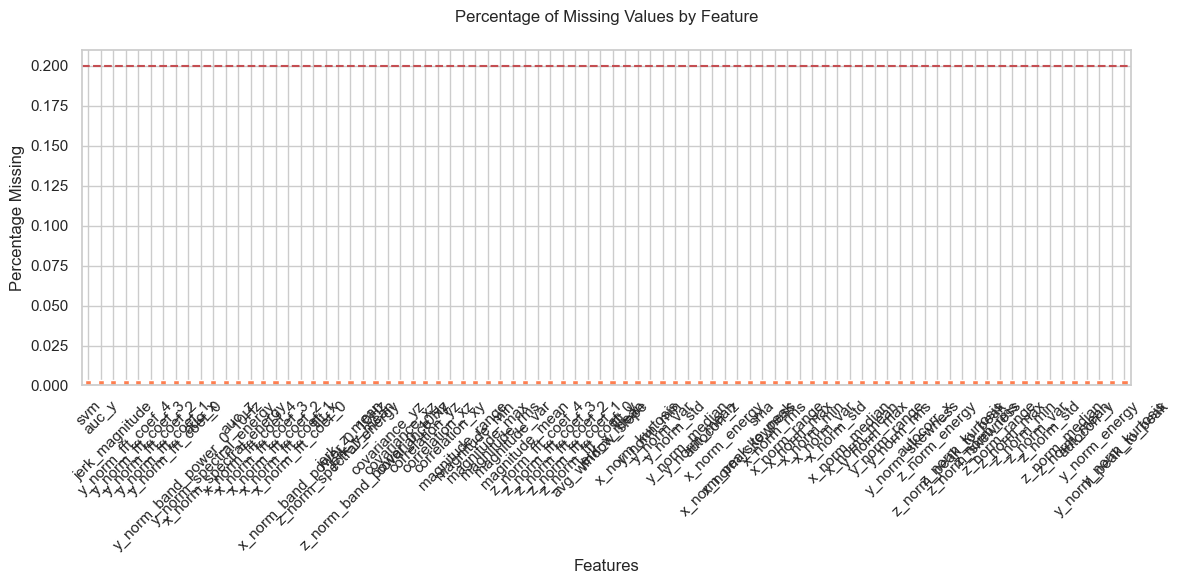


Handling missing values...

Visualizing feature distributions...


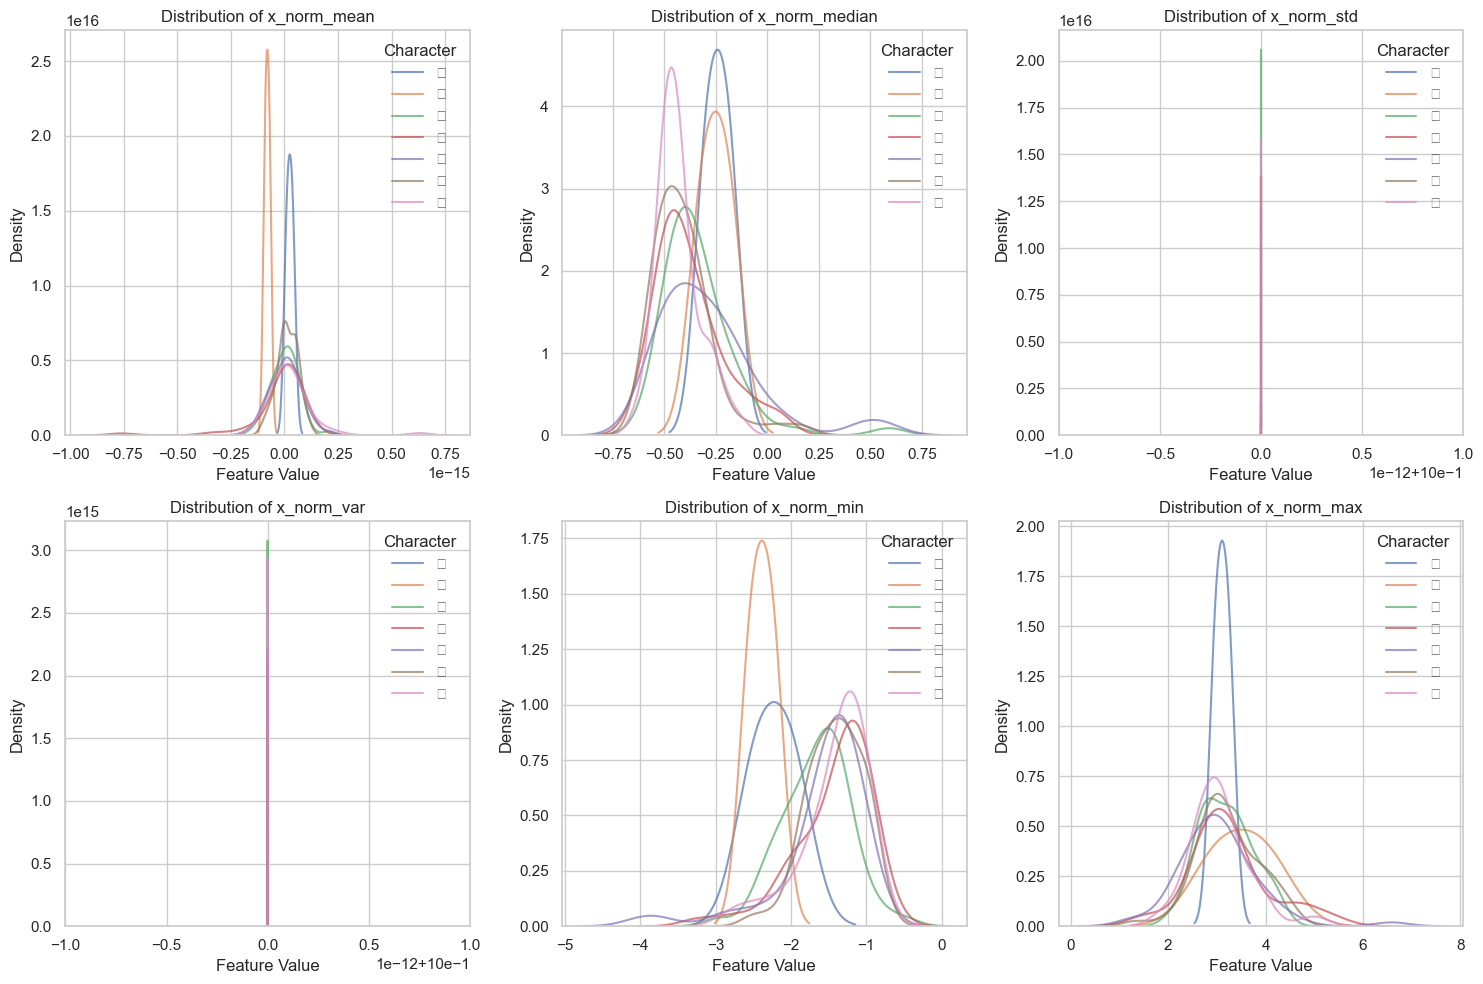

TypeError: visualize_anova_results() missing 1 required positional argument: 'X_data'

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import missingno as msno

# Set up visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

def visualize_missing_data(df):
    """Create visualizations for missing data patterns"""
    print("\nVisualizing missing data patterns...")
    
    plt.figure(figsize=(12, 6))
    msno.matrix(df.sample(min(500, len(df))))  # Sample for large datasets
    plt.title("Missing Data Pattern", pad=20)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    missing_percent = df.isnull().mean().sort_values(ascending=False)
    missing_percent[missing_percent > 0].plot.bar(color='coral')
    plt.axhline(y=0.2, color='r', linestyle='--')
    plt.title("Percentage of Missing Values by Feature", pad=20)
    plt.ylabel("Percentage Missing")
    plt.xlabel("Features")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def visualize_feature_distributions(X, y, class_names):
    """Visualize distributions of top features"""
    print("\nVisualizing feature distributions...")
    
    # Select a few representative features
    sample_features = X.columns[:6] if len(X.columns) >= 6 else X.columns
    
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(sample_features, 1):
        plt.subplot(2, 3, i)
        for char_class in np.unique(y):
            sns.kdeplot(X.loc[y == char_class, feature], 
                        label=class_names[char_class],
                        alpha=0.7)
        plt.title(f"Distribution of {feature}")
        plt.xlabel("Feature Value")
        plt.ylabel("Density")
        plt.legend(title="Character")
    plt.tight_layout()
    plt.show()

def visualize_anova_results(anova_results, X_data):
    """Create comprehensive visualizations of ANOVA results including correlation heatmap"""
    print("\nVisualizing ANOVA results...")

    # Filter significant features (p < 0.05)
    significant_features = anova_results[anova_results['p_value'] < 0.05].sort_values('F_value', ascending=False)
    num_features = len(significant_features)
    print(f"Number of statistically significant features (p < 0.05): {num_features}")

    # Dynamic figure height based on number of features
    height_per_feature = 0.4
    barplot_height = max(6, num_features * height_per_feature)

    # Create a 4-panel figure (added heatmap)
    fig = plt.figure(figsize=(16, barplot_height + 14))
    gs = fig.add_gridspec(4, 1)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    ax4 = fig.add_subplot(gs[3])  # New axis for heatmap

    # Plot 1: Feature importance (F-values)
    sns.barplot(x='F_value', y='Feature', data=significant_features,
                palette="viridis", ax=ax1)
    ax1.set_title(f'Significant Features (p < 0.05) by ANOVA F-value', pad=15, fontsize=14)
    ax1.set_xlabel('F-value (higher = more important)', labelpad=10)
    ax1.set_ylabel('Feature', labelpad=10)

    # Add p-value annotations
    for i, (_, row) in enumerate(significant_features.iterrows()):
        ax1.text(row['F_value'] + 0.1, i,
                 f"p={row['p_value']:.1e}",
                 va='center', fontsize=9)

    # Plot 2: P-value distribution
    sns.histplot(anova_results['p_value'], bins=30,
                 kde=True, color='skyblue', ax=ax2)
    ax2.axvline(0.05, color='red', linestyle='--',
                label='p=0.05 threshold')
    ax2.set_title('Distribution of p-values from ANOVA Test', pad=15, fontsize=14)
    ax2.set_xlabel('p-value', labelpad=10)
    ax2.set_ylabel('Count', labelpad=10)
    ax2.legend()

    # Plot 3: F-value vs p-value scatter
    significant = anova_results['p_value'] < 0.05
    sns.scatterplot(x='F_value', y='p_value',
                    hue=significant, palette={True: 'green', False: 'red'},
                    size=np.log(anova_results['p_value'] + 1e-100),
                    sizes=(20, 200), alpha=0.7,
                    data=anova_results, ax=ax3)
    ax3.set_yscale('log')
    ax3.axhline(0.05, color='red', linestyle='--')
    ax3.set_title('Feature Importance: F-value vs p-value', pad=15, fontsize=14)
    ax3.set_xlabel('F-value', labelpad=10)
    ax3.set_ylabel('p-value (log scale)', labelpad=10)
    ax3.legend(title='Significant (p < 0.05)')

    # Plot 4: Correlation heatmap of significant features
    if num_features > 0:
        # Get the data for significant features only
        sig_feature_names = significant_features['Feature'].values
        sig_feature_data = X_data[sig_feature_names]
        
        # Calculate correlation matrix
        corr_matrix = sig_feature_data.corr()
        
        # Create heatmap
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                    center=0, vmin=-1, vmax=1, ax=ax4)
        ax4.set_title('Correlation Heatmap of Significant Features', pad=15, fontsize=14)
        
        # Rotate x-axis labels for better readability
        plt.setp(ax4.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    else:
        ax4.text(0.5, 0.5, 'No significant features to show correlation', 
                 ha='center', va='center', fontsize=12)
        ax4.set_title('Correlation Heatmap (no significant features)', pad=15, fontsize=14)
        ax4.axis('off')

    plt.tight_layout()
    plt.show()



def main():
    # Load and preprocess data
    filepath = 'all_features.csv'
    df = pd.read_csv(filepath)
    
    # Extract character label from filename
    df['character'] = df['file_name'].str.split('_').str[0]
    
    # Visualize missing data before handling
    visualize_missing_data(df)
    
    # Drop unnecessary columns
    cols_to_drop = ['file_name', 'char_name']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
    
    # Handle missing values
    print("\nHandling missing values...")
    df = df.dropna(axis=1, thresh=0.8*len(df))  # Drop cols with >20% missing
    
    imputer = SimpleImputer(strategy='median')
    num_cols = df.select_dtypes(include=np.number).columns
    df[num_cols] = imputer.fit_transform(df[num_cols])
    
    # Encode character labels
    le = LabelEncoder()
    df['character'] = le.fit_transform(df['character'])
    class_names = le.classes_
    
    # Separate features and target
    X = df.drop(columns=['character'])
    y = df['character']
    
    # Visualize feature distributions
    visualize_feature_distributions(X, y, class_names)
    
    # Perform ANOVA
    f_values, p_values = f_classif(X, y)
    anova_results = pd.DataFrame({
        'Feature': X.columns,
        'F_value': f_values,
        'p_value': p_values
    }).sort_values('F_value', ascending=False)
    
    # Visualize ANOVA results
    visualize_anova_results(anova_results)
    
    # Save results
    anova_results.to_csv('anova_feature_importance.csv', index=False)
    print("\nANOVA results saved to 'anova_feature_importance.csv'")

if __name__ == "__main__":
    main()

Performing character-wise ANOVA tests on numeric features...

Top 20 most significant features:
             Feature  F_statistic      p_value
       covariance_yz    23.820273 1.140870e-22
      correlation_yz    23.818293 1.145220e-22
z_norm_dominant_freq    19.147847 1.207622e-18
   y_norm_fft_coef_4    17.496872 3.678836e-17
   z_norm_fft_coef_4    10.563722 1.472987e-10
   y_norm_fft_coef_3     9.854388 7.534832e-10
          y_norm_min     8.638498 1.273447e-08
          z_norm_max     7.739913 1.051179e-07
        z_norm_range     6.841026 8.808592e-07
 z_norm_peak_to_peak     6.841026 8.808592e-07
     y_norm_skewness     5.810453 1.018670e-05
          z_norm_min     5.709855 1.293896e-05
       x_norm_median     4.563301 1.963623e-04
               auc_y     4.176475 4.884591e-04
       magnitude_min     4.094413 5.922093e-04
          x_norm_min     3.899491 9.345814e-04
          autocorr_x     3.679150 1.561437e-03
          autocorr_z     3.651417 1.665286e-03
       z_no

<Figure size 1200x600 with 0 Axes>

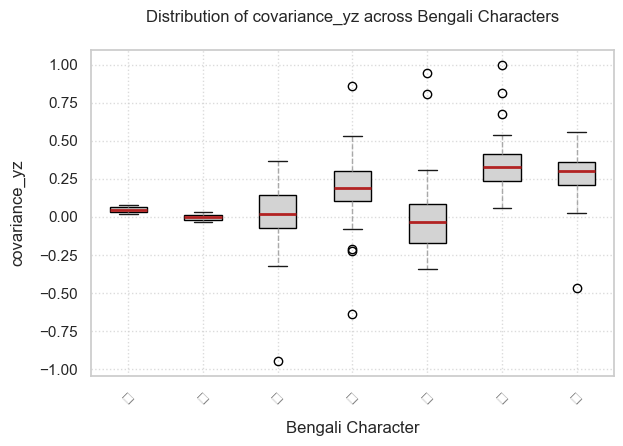

<Figure size 1200x600 with 0 Axes>

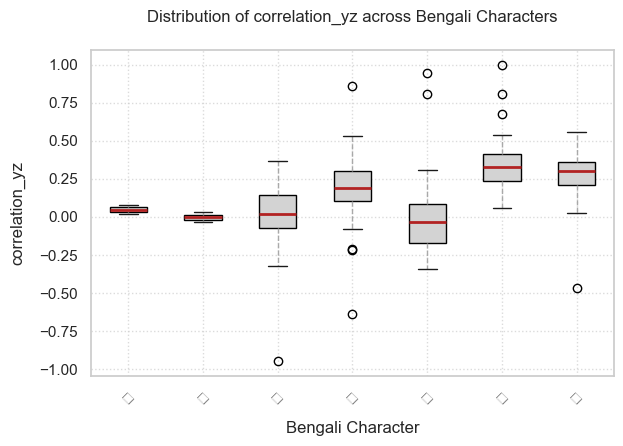

<Figure size 1200x600 with 0 Axes>

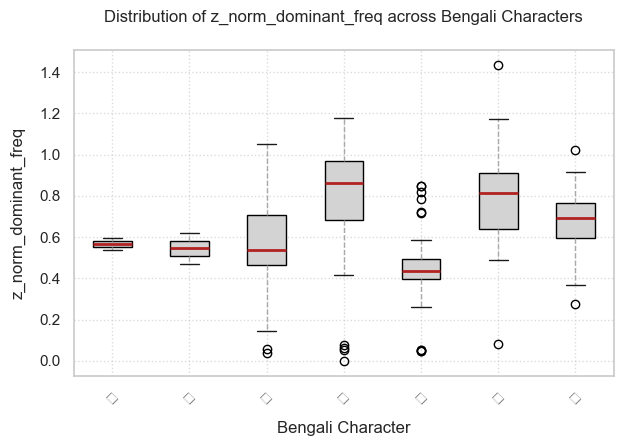

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import LabelEncoder

def load_data(filepath):
    """Load and preprocess the dataset"""
    df = pd.read_csv(filepath)
    
    # Extract character label from filename (first character before underscore)
    df['character'] = df['file_name'].str.split('_').str[0]
    
    # Drop unnecessary columns
    cols_to_drop = ['file_name', 'char_name']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
    
    # Handle missing values - only for numeric columns
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols] = df[numeric_cols].dropna(axis=1, thresh=0.8*len(df))  # Drop numeric cols with >20% missing
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())  # Fill remaining with median
    
    return df

def character_wise_anova(df, feature):
    """Perform ANOVA for a specific feature across characters"""
    groups = [group[feature].values for name, group in df.groupby('character')]
    f_stat, p_value = f_oneway(*groups)
    return f_stat, p_value

def perform_all_anovas(df):
    """Perform ANOVA for all numeric features against character labels"""
    results = []
    numeric_features = df.select_dtypes(include=np.number).columns
    
    for feature in numeric_features:
        f_stat, p_value = character_wise_anova(df, feature)
        results.append({
            'Feature': feature,
            'F_statistic': f_stat,
            'p_value': p_value
        })
    
    return pd.DataFrame(results).sort_values('F_statistic', ascending=False)

def plot_character_distributions(df, feature):
    """Plot distribution of a numeric feature across characters"""
    plt.figure(figsize=(12, 6))
    
    # Create boxplot with custom styling
    boxprops = dict(linestyle='-', linewidth=1.5, color='gray')
    whiskerprops = dict(linestyle='--', linewidth=1, color='darkgray')
    medianprops = dict(linestyle='-', linewidth=2, color='firebrick')
    
    df.boxplot(column=feature, by='character', 
               patch_artist=True,
               boxprops=dict(facecolor='lightgray'),
               whiskerprops=whiskerprops,
               medianprops=medianprops,
               grid=False)
    
    plt.title(f'Distribution of {feature} across Bengali Characters', pad=20)
    plt.suptitle('')  # Remove default subtitle
    plt.xlabel('Bengali Character', labelpad=10)
    plt.ylabel(feature, labelpad=10)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

def main():
    # Load your dataset
    filepath = 'all_features.csv'
    df = load_data(filepath)
    
    # Perform all ANOVAs on numeric features only
    print("Performing character-wise ANOVA tests on numeric features...")
    anova_results = perform_all_anovas(df)
    
    # Display top results
    print("\nTop 20 most significant features:")
    print(anova_results.head(20).to_string(index=False))
    
    # Save results
    anova_results.to_csv('character_wise_anova_results.csv', index=False)
    print("\nResults saved to 'character_wise_anova_results.csv'")
    
    # Plot distributions for top 3 features
    top_features = anova_results.head(3)['Feature'].values
    for feature in top_features:
        plot_character_distributions(df, feature)
    
    # Visualize ANOVA results with heatmap
    visualize_anova_results(anova_results, X)


if __name__ == "__main__":
    main()


Visualizing missing data patterns...


<Figure size 1200x600 with 0 Axes>

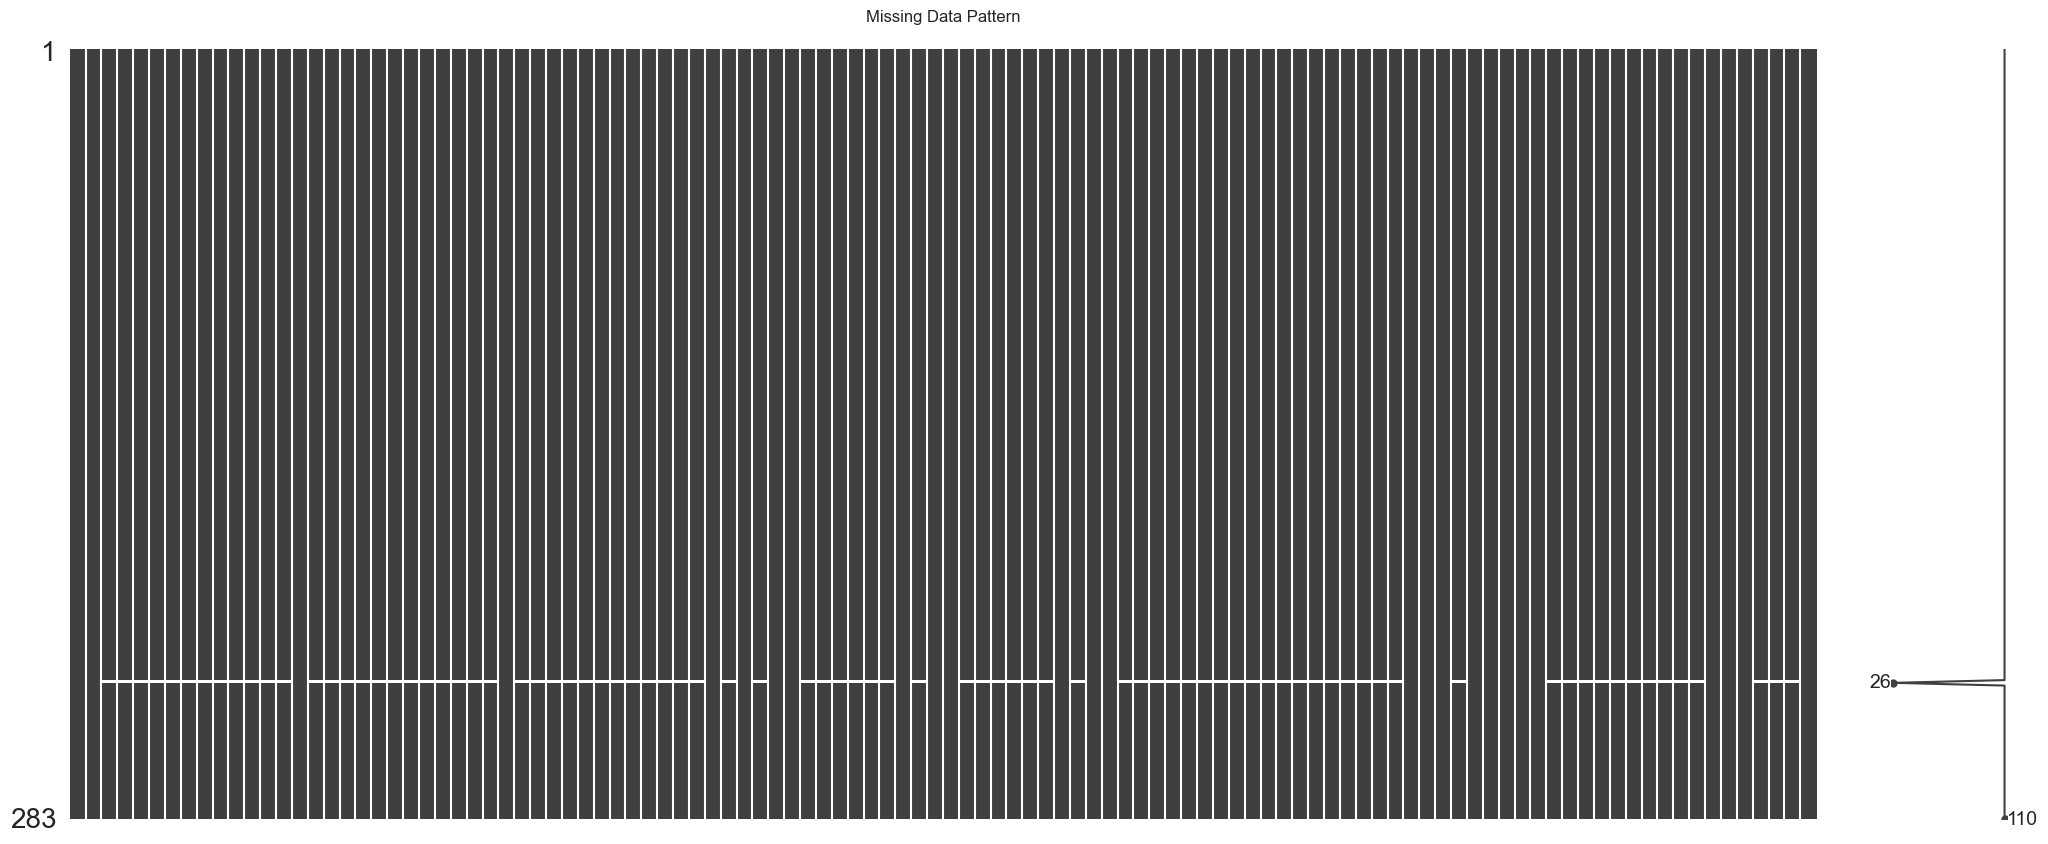

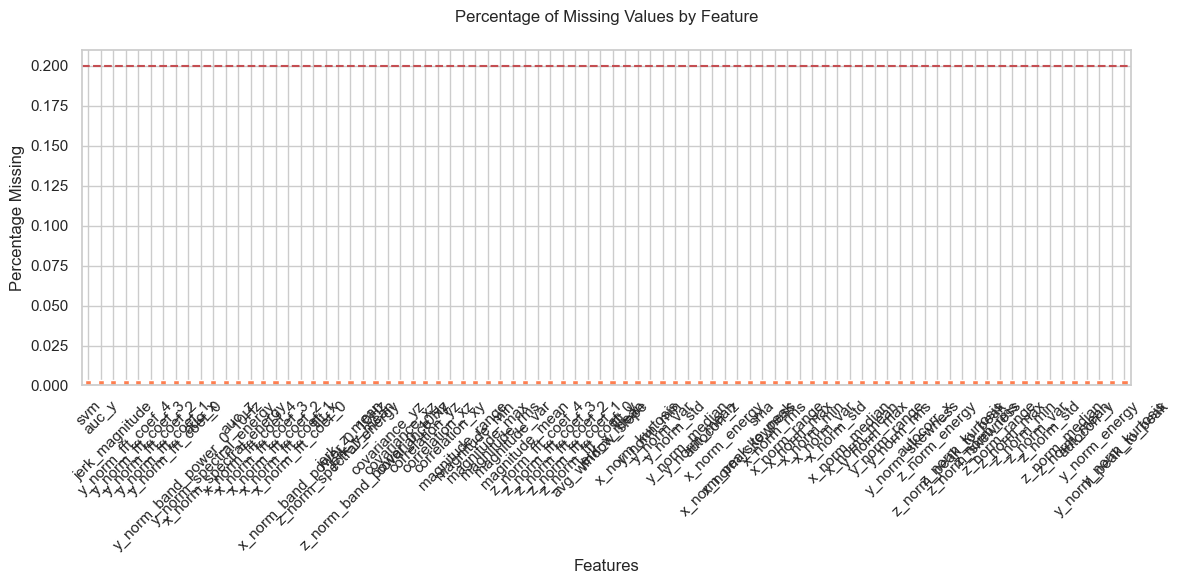


Handling missing values...

Visualizing feature distributions...


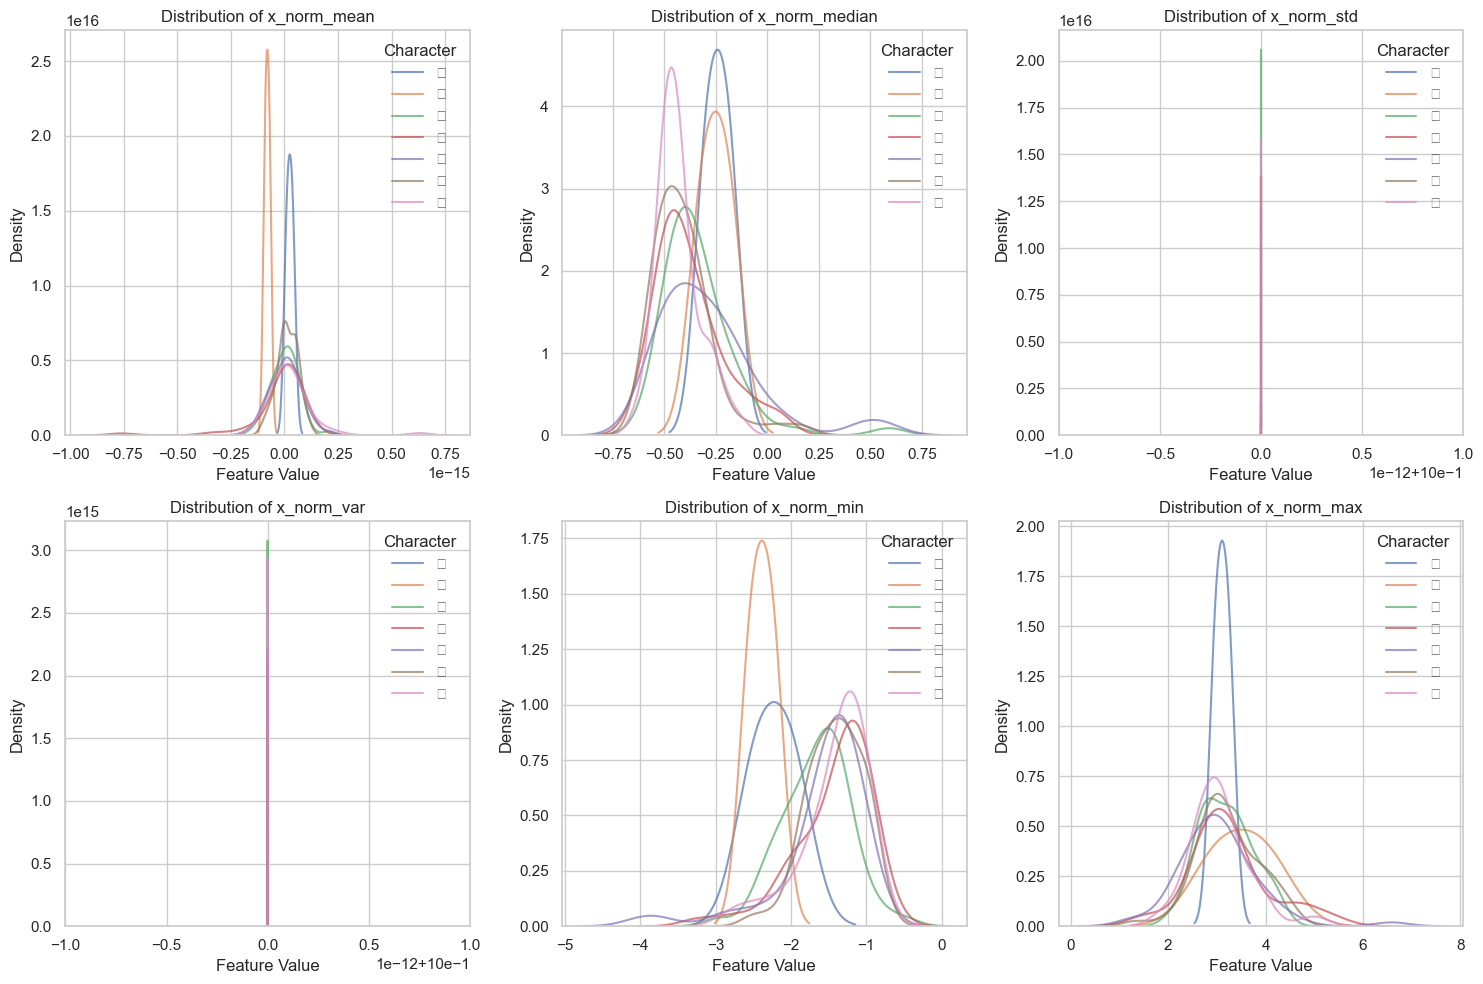


Visualizing ANOVA results...
Number of statistically significant features (p < 0.05): 49


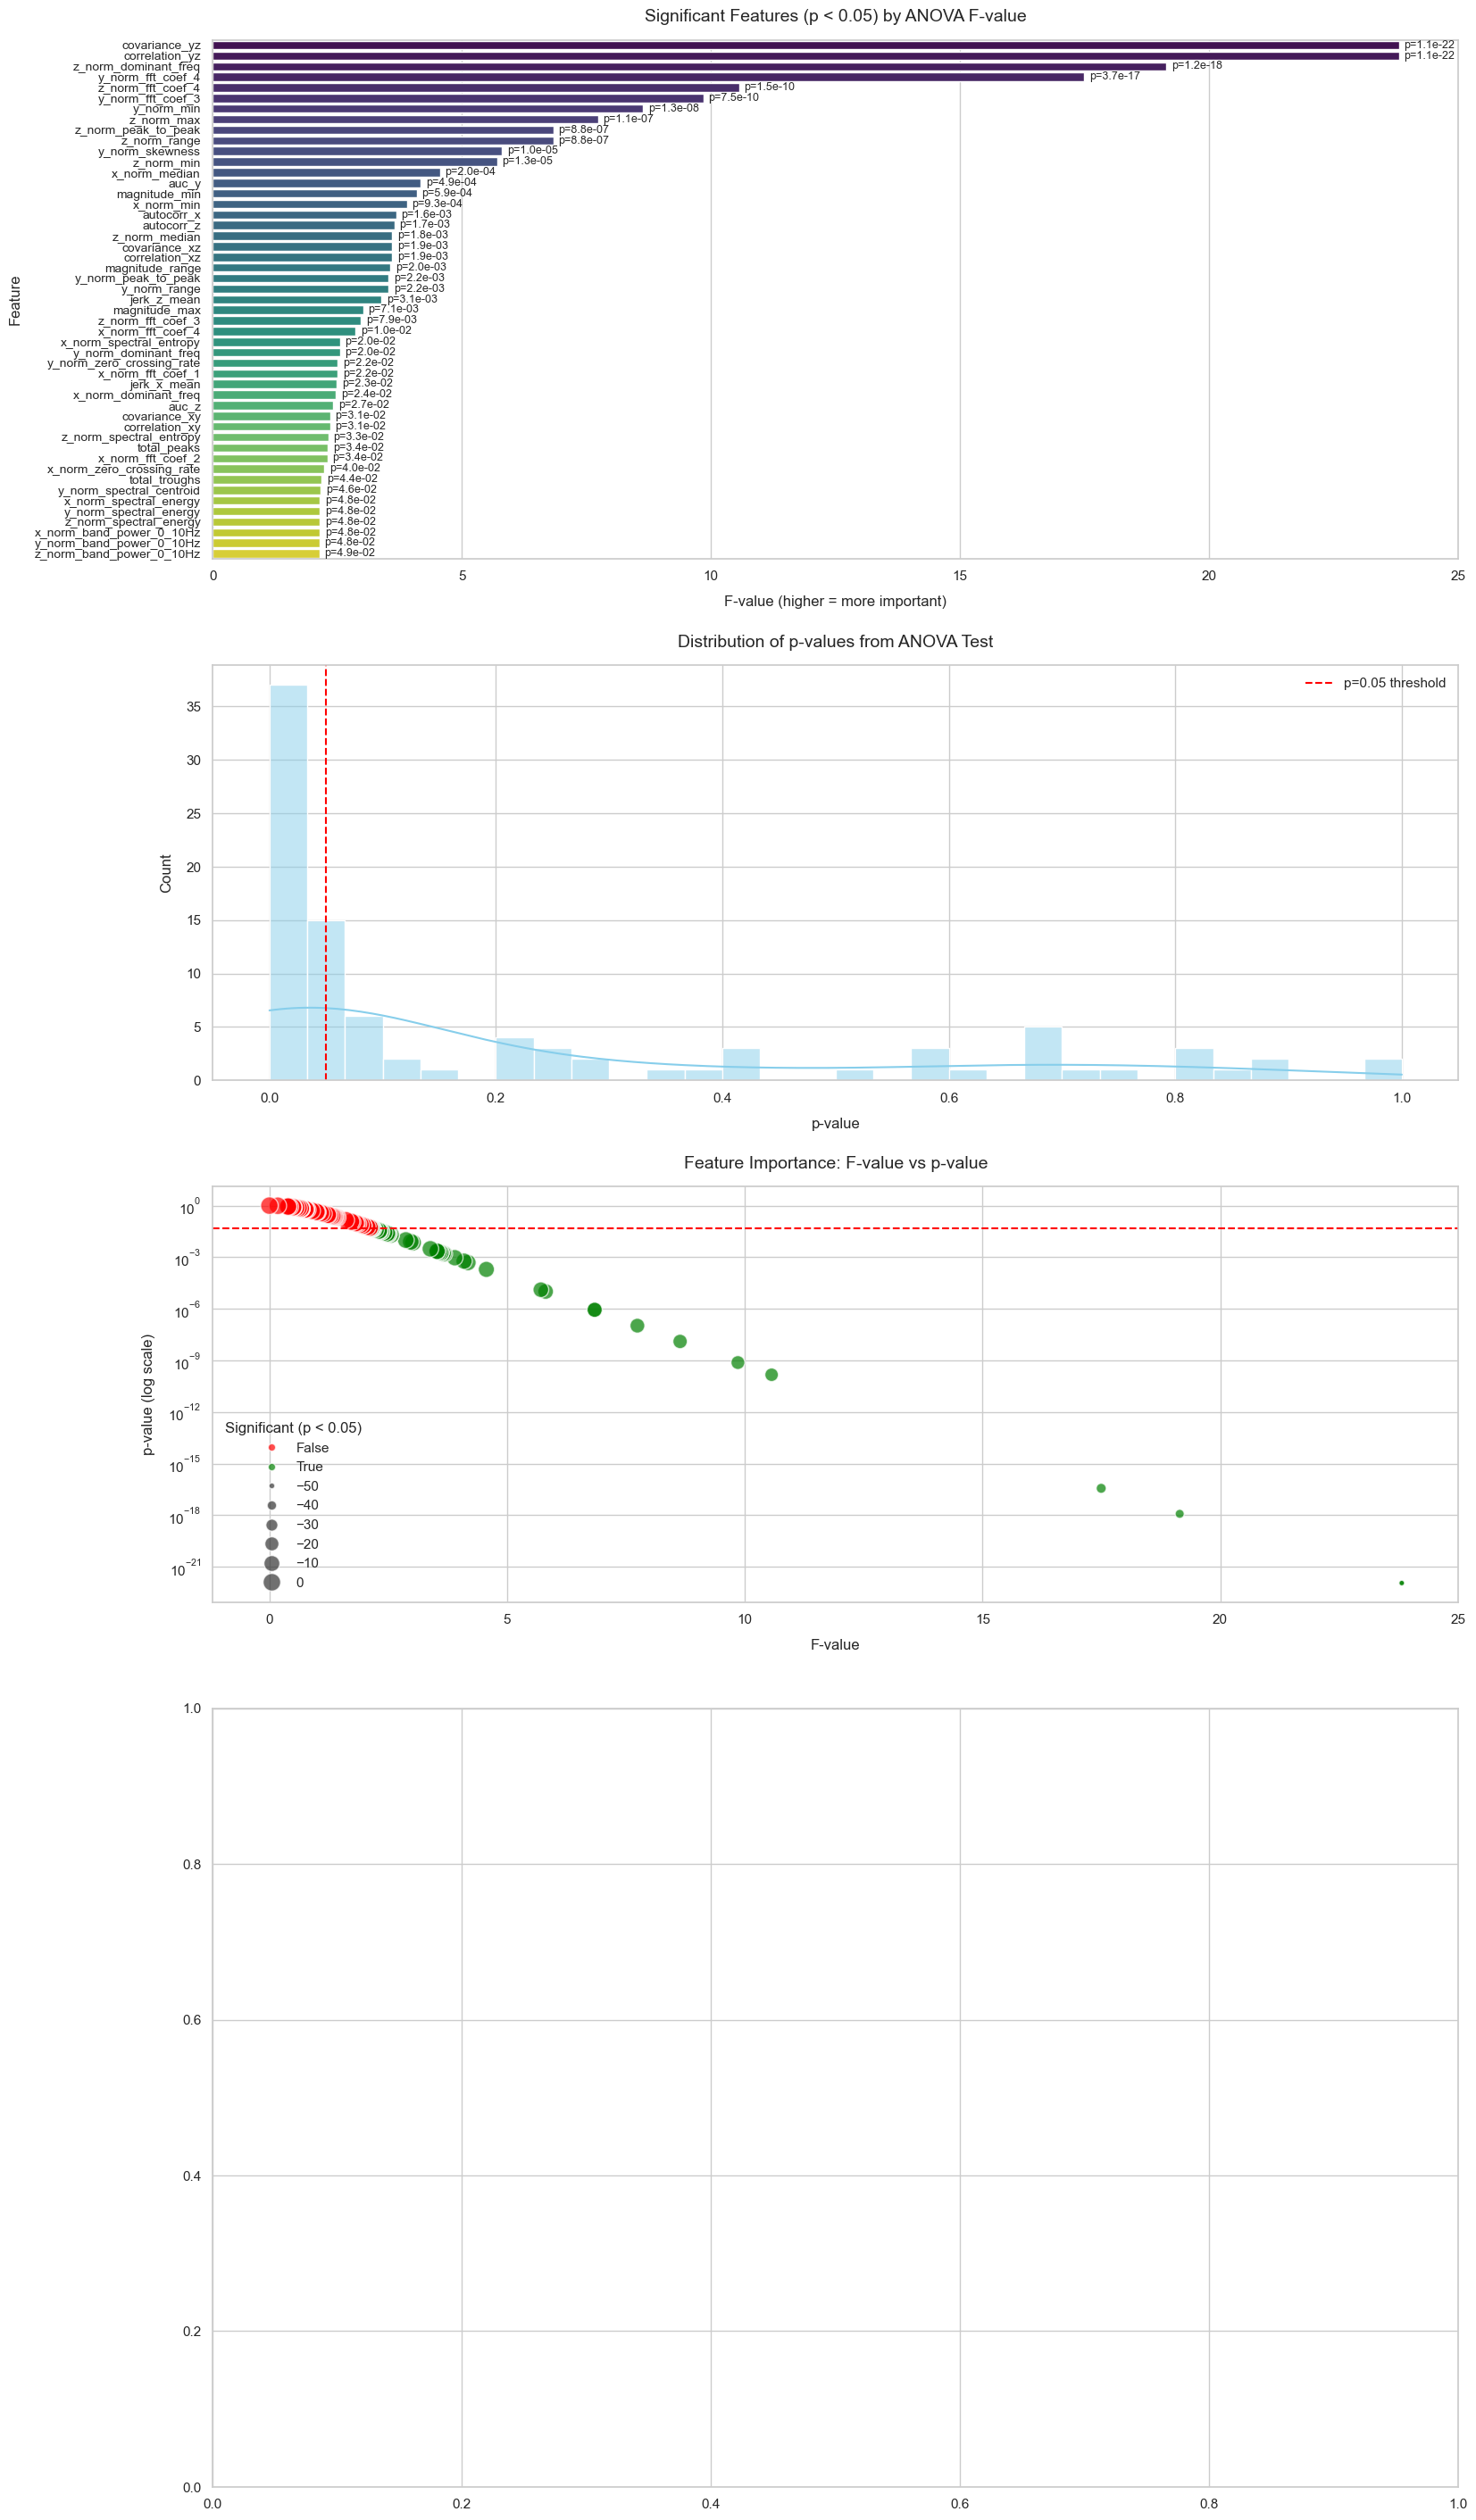

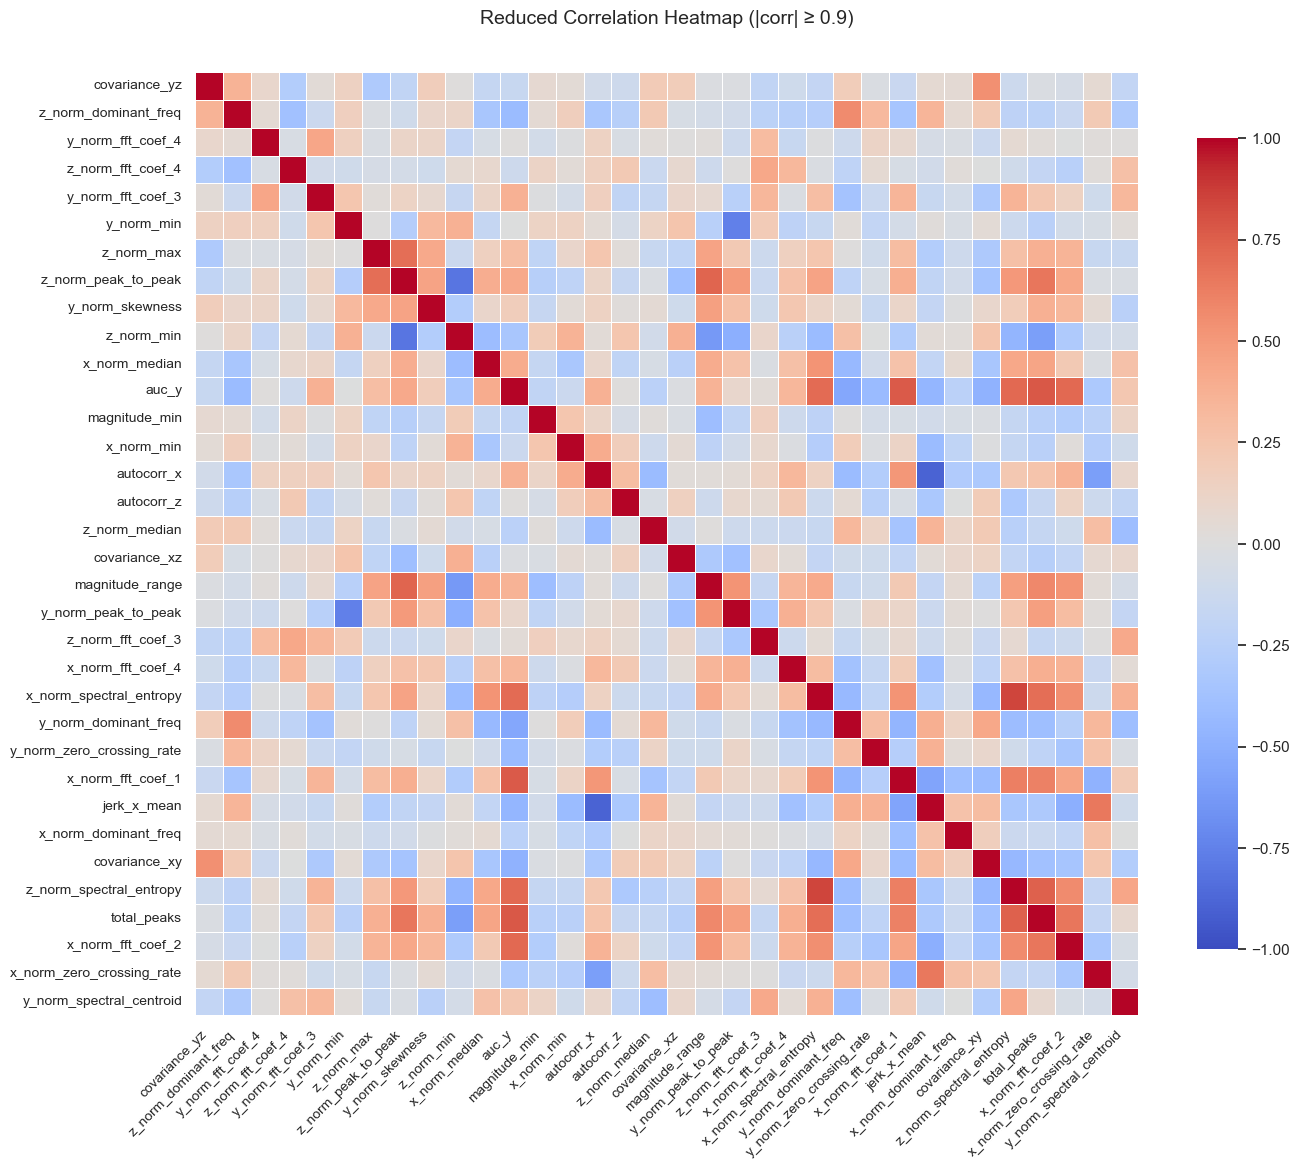

<Figure size 640x480 with 0 Axes>


ANOVA results saved to 'anova_feature_importance.csv'


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import missingno as msno

# Set up visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

def visualize_missing_data(df):
    """Create visualizations for missing data patterns"""
    print("\nVisualizing missing data patterns...")
    
    plt.figure(figsize=(12, 6))
    msno.matrix(df.sample(min(500, len(df))))  # Sample for large datasets
    plt.title("Missing Data Pattern", pad=20)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    missing_percent = df.isnull().mean().sort_values(ascending=False)
    missing_percent[missing_percent > 0].plot.bar(color='coral')
    plt.axhline(y=0.2, color='r', linestyle='--')
    plt.title("Percentage of Missing Values by Feature", pad=20)
    plt.ylabel("Percentage Missing")
    plt.xlabel("Features")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def visualize_feature_distributions(X, y, class_names):
    """Visualize distributions of top features"""
    print("\nVisualizing feature distributions...")
    
    # Select a few representative features
    sample_features = X.columns[:6] if len(X.columns) >= 6 else X.columns
    
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(sample_features, 1):
        plt.subplot(2, 3, i)
        for char_class in np.unique(y):
            sns.kdeplot(X.loc[y == char_class, feature], 
                        label=class_names[char_class],
                        alpha=0.7)
        plt.title(f"Distribution of {feature}")
        plt.xlabel("Feature Value")
        plt.ylabel("Density")
        plt.legend(title="Character")
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_anova_results(anova_results, X_data):
    """Create comprehensive visualizations of ANOVA results including reduced correlation heatmap"""
    print("\nVisualizing ANOVA results...")

    # Filter significant features (p < 0.05)
    significant_features = anova_results[anova_results['p_value'] < 0.05].sort_values('F_value', ascending=False)
    num_features = len(significant_features)
    print(f"Number of statistically significant features (p < 0.05): {num_features}")

    # Dynamic figure height
    height_per_feature = 0.4
    barplot_height = max(6, num_features * height_per_feature)

    # Create figure with 4 panels
    fig = plt.figure(figsize=(18, barplot_height + 16))
    gs = fig.add_gridspec(4, 1, height_ratios=[1, 0.8, 0.8, 1.5])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    ax4 = fig.add_subplot(gs[3])

    # Plot 1: Feature importance
    sns.barplot(x='F_value', y='Feature', data=significant_features,
                palette="viridis", ax=ax1)
    ax1.set_title(f'Significant Features (p < 0.05) by ANOVA F-value', pad=15, fontsize=14)
    ax1.set_xlabel('F-value (higher = more important)', labelpad=10)
    ax1.set_ylabel('Feature', labelpad=10)
    ax1.tick_params(axis='y', labelsize=10)

    # Add p-value annotations
    for i, (_, row) in enumerate(significant_features.iterrows()):
        ax1.text(row['F_value'] + 0.1, i,
                 f"p={row['p_value']:.1e}",
                 va='center', fontsize=9)

    # Plot 2: P-value distribution
    sns.histplot(anova_results['p_value'], bins=30,
                 kde=True, color='skyblue', ax=ax2)
    ax2.axvline(0.05, color='red', linestyle='--',
                label='p=0.05 threshold')
    ax2.set_title('Distribution of p-values from ANOVA Test', pad=15, fontsize=14)
    ax2.set_xlabel('p-value', labelpad=10)
    ax2.set_ylabel('Count', labelpad=10)
    ax2.legend()

    # Plot 3: F-value vs p-value scatter
    significant = anova_results['p_value'] < 0.05
    sns.scatterplot(x='F_value', y='p_value',
                    hue=significant, palette={True: 'green', False: 'red'},
                    size=np.log(anova_results['p_value'] + 1e-100),
                    sizes=(20, 200), alpha=0.7,
                    data=anova_results, ax=ax3)
    ax3.set_yscale('log')
    ax3.axhline(0.05, color='red', linestyle='--')
    ax3.set_title('Feature Importance: F-value vs p-value', pad=15, fontsize=14)
    ax3.set_xlabel('F-value', labelpad=10)
    ax3.set_ylabel('p-value (log scale)', labelpad=10)
    ax3.legend(title='Significant (p < 0.05)')

    # Plot 4: Reduced Correlation Heatmap
    if num_features > 0:
        sig_feature_names = significant_features['Feature'].values
        sig_feature_data = X_data[sig_feature_names]

        # Calculate correlation matrix
        corr_matrix = sig_feature_data.corr()
        abs_corr = corr_matrix.abs()

        # Find strongly correlated pairs (|corr| >= 0.9)
        strong_pairs = [(col, row)
                        for i, col in enumerate(abs_corr.columns)
                        for j, row in enumerate(abs_corr.columns)
                        if i < j and abs_corr.loc[row, col] >= 0.9]

        # Drop one feature from each strongly correlated pair
        features_to_drop = set()
        for col, row in strong_pairs:
            if col not in features_to_drop and row not in features_to_drop:
                features_to_drop.add(row)

        reduced_features = [f for f in sig_feature_names if f not in features_to_drop]
        reduced_data = sig_feature_data[reduced_features]
        reduced_corr_matrix = reduced_data.corr()

        # Plot heatmap
        plt.figure(figsize=(14, 12))
        heatmap = sns.heatmap(
            reduced_corr_matrix,
            annot=False,  # <--- No numbers inside boxes
            fmt=".2f",
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1,
            linewidths=0.5,
            square=True,
            cbar_kws={"shrink": 0.8}
        )
        heatmap.set_title('Reduced Correlation Heatmap (|corr| ≥ 0.9)\n', fontsize=14, pad=20)

        heatmap.set_xticklabels(
            heatmap.get_xticklabels(),
            rotation=45,
            horizontalalignment='right',
            fontsize=10
        )
        heatmap.set_yticklabels(
            heatmap.get_yticklabels(),
            rotation=0,
            fontsize=10
        )

        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        ax4.text(0.5, 0.5, 'No significant features to show correlation',
                 ha='center', va='center', fontsize=12)
        ax4.set_title('Correlation Heatmap (no significant features)', pad=15, fontsize=14)
        ax4.axis('off')

    plt.tight_layout()
    plt.show()



def main():
    # Load and preprocess data
    filepath = 'all_features.csv'
    df = pd.read_csv(filepath)
    
    # Extract character label from filename
    df['character'] = df['file_name'].str.split('_').str[0]
    
    # Visualize missing data before handling
    visualize_missing_data(df)
    
    # Drop unnecessary columns
    cols_to_drop = ['file_name', 'char_name']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
    
    # Handle missing values
    print("\nHandling missing values...")
    df = df.dropna(axis=1, thresh=0.8*len(df))  # Drop cols with >20% missing
    
    imputer = SimpleImputer(strategy='median')
    num_cols = df.select_dtypes(include=np.number).columns
    df[num_cols] = imputer.fit_transform(df[num_cols])
    
    # Encode character labels
    le = LabelEncoder()
    df['character'] = le.fit_transform(df['character'])
    class_names = le.classes_
    
    # Separate features and target
    X = df.drop(columns=['character'])
    y = df['character']
    
    # Visualize feature distributions
    visualize_feature_distributions(X, y, class_names)
    
    # Perform ANOVA
    f_values, p_values = f_classif(X, y)
    anova_results = pd.DataFrame({
        'Feature': X.columns,
        'F_value': f_values,
        'p_value': p_values
    }).sort_values('F_value', ascending=False)
    
    # Visualize ANOVA results (now passing X as the second parameter)
    visualize_anova_results(anova_results, X)
    
    # Save results
    anova_results.to_csv('anova_feature_importance.csv', index=False)
    print("\nANOVA results saved to 'anova_feature_importance.csv'")

if __name__ == "__main__":
    main()

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Load your reduced features CSV
df = pd.read_csv("all_features.csv")  # name should match your reduced file

# Separate features and labels
X = df.drop(columns=["file_name", "char_name"])  # drop metadata
y = df["char_name"]

# Encode character labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

# Train SGD Classifier
sgd = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train)

# Predict and evaluate
y_pred = sgd.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.